In [25]:
"""
@inproceedings{
    manor2024posterior,
    title={On the Posterior Distribution in Denoising: Application to Uncertainty Quantification},
    author={Hila Manor and Tomer Michaeli},
    booktitle={The Twelfth International Conference on Learning Representations},
    year={2024},
    url={https://openreview.net/forum?id=adSGeugiuj}
}
"""
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
import os
import subprocess # inkspace
from scipy.linalg import toeplitz
plt.rcParams["text.usetex"] = True
np.random.seed(30)
# import seaborn as sns
# sns.set_style('white')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "cmu-serif",
    "mathtext.fontset": "cm",
    "font.size": 18
})

In [26]:
def sample_multivariate_gaussian_mixture(M: int, mus: np.array, sigmas: np.array, N: int = 10000, weights: np.array = None) -> np.array:
    """
    Sample data points from a Gaussian Mixture Model (GMM) using the Component Selection Method.
    
    This function first generates samples from all individual multivariate Gaussian distributions 
    and then selects one component per data point based on the given mixture weights.

    Sampling process:
    1. Generate an array of shape (N, d, M), where each column represents samples drawn from 
       a different Gaussian component.
    2. Randomly select one component for each data point according to the specified `weights`.
    3. Return the selected samples, ensuring that the final output has the shape (N, d).

    Parameters:
        M (int): Number of Gaussian components in the mixture.
        mus (list of np.array): List of mean vectors for each Gaussian component, 
                                where each element is a (d,) numpy array.
        sigmas (list of np.array): List of covariance matrices for each Gaussian component, 
                                   where each element is a (d, d) numpy array.
        N (int): Number of data points to sample.
        weights (list or np.array, optional): Probability weights for selecting each Gaussian 
                                              component. If None, all components are assumed 
                                              to be equally weighted (1/M).

    Returns:
        np.array: An array of shape (N, d), where each row is a sampled data point.
    """

    assert (M == len(mus))
    
    samples = np.zeros((N, len(mus[0]), M), dtype=np.float64)
    for i in range(M):
        samples[:, :, i] = np.random.multivariate_normal(mus[i], sigmas[i], size=(N,)).astype(np.float64)

    if weights is None:
        weights = np.ones(M, dtype=np.float64) / M
    random_idx = np.random.choice(np.arange(M), size=(N,), p=weights)
    return samples[np.arange(N), :, random_idx]


def mu1_real(y: np.array ,A: np.array, sigma1: np.array, sigma2: np.array, Nsigma: np.array, m1: np.array, m2: np.array) -> np.array:
    """
    Calculates the theoretical posterier E(x|y) of a two-component GMM.
    Note np.lingalg.pinv can take care of invertable matrix and singular matrix. 
    Non-singular matirx -> normal inverse.
    Singular matrix -> pseudo inverse.
        y: (d, N), blurred image
        A: (N, N), The toeplitz matrix of the blurring process 
        sigma1: (d, d). The covariance matrix 1
        sigma2: (d, d). The covariance matrix 2
        Nsigma; (d, d). The covariance matrix of the noise. Non-diagonal elements are all zero.
        m1, m2: (d, 1). prior mean of two component distributions
    """
    y = y.astype(np.float64)
    
    mu1_post = m1 + sigma1 @ A.T @ np.linalg.inv(A @ sigma1 @ A.T + Nsigma) @ (y - A @ m1)
    mu2_post = m2 + sigma2 @ A.T @ np.linalg.inv(A @ sigma2 @ A.T + Nsigma) @ (y - A @ m2)

    # Calculate the weights of individual Gaussian distributions.
    p1 = np.diag(np.exp(-0.5 * (y - A @ m1).T @ np.linalg.pinv(A @ sigma1 @ A.T + Nsigma) @ (y - A @ m1)))
    p2 = np.diag(np.exp(-0.5 * (y - A @ m2).T @ np.linalg.pinv(A @ sigma2 @ A.T + Nsigma) @ (y - A @ m2)))

    return (mu1_post * p1 + mu2_post * p2) / (p1 + p2)


def px_pdf_real(xs, sigma1, sigma2, m1, m2):
    # Calculate the pdf of a wo-component Gaussian Mixture Model (GMM)
    xs = xs.astype(np.float64)
    norm_const1 = 1 / (2* np.pi * np.linalg.det(sigma1))
    norm_const2 = 1 / (2* np.pi * np.linalg.det(sigma2))
    pdf1 = norm_const1 * np.diag(np.exp(-0.5 * (xs - m1).T @ np.linalg.inv((sigma1)) @ (xs - m1)))
    pdf2 = norm_const2 * np.diag(np.exp(-0.5 * (xs - m2).T @ np.linalg.inv((sigma2)) @ (xs - m2)))
    return 0.5 * pdf1 + 0.5 * pdf2



In [28]:


# GMM sampling
mus = [np.array([1, 2]), np.array([8, 10])]
sigmas = [np.array([[1, 0], [0, 2]]), np.array([[2, 1], [1, 1]])]
sigma1, sigma2 = sigmas
m1, m2 = mus
m1, m2 = m1.reshape(2,1), m2.reshape(2,1)
x = sample_multivariate_gaussian_mixture(2, mus, sigmas, weights=np.array([0.5, 0.5])).astype(np.float64)
x = x.T 
# Generate a random linear Transformation
A = arr_normal = np.random.randn(2, 2)

# Generagte noise
noise_sigma2 = 4
Nsigma = noise_sigma2 * np.eye(2)
n = np.random.multivariate_normal(np.array([0, 0]), Nsigma, (len(x.T),)).astype(np.float64).T

# create y
y = A @ x + n



In [29]:
# 分割训练集和测试集
train_samples_x = x[:, :int(x.shape[-1] * 0.8)]
test_samples_x  = x[:, int(x.shape[-1] * 0.8):]
train_samples_y = y[:, :int(y.shape[-1] * 0.8)]
test_samples_y  = y[:, int(y.shape[-1] * 0.8):]

In [17]:
import matplotlib.pyplot as plt

print(plt.rcParams["text.usetex"])


False


Text(0.5, 1.0, '$p(x)$ vs $p(x|y)$')

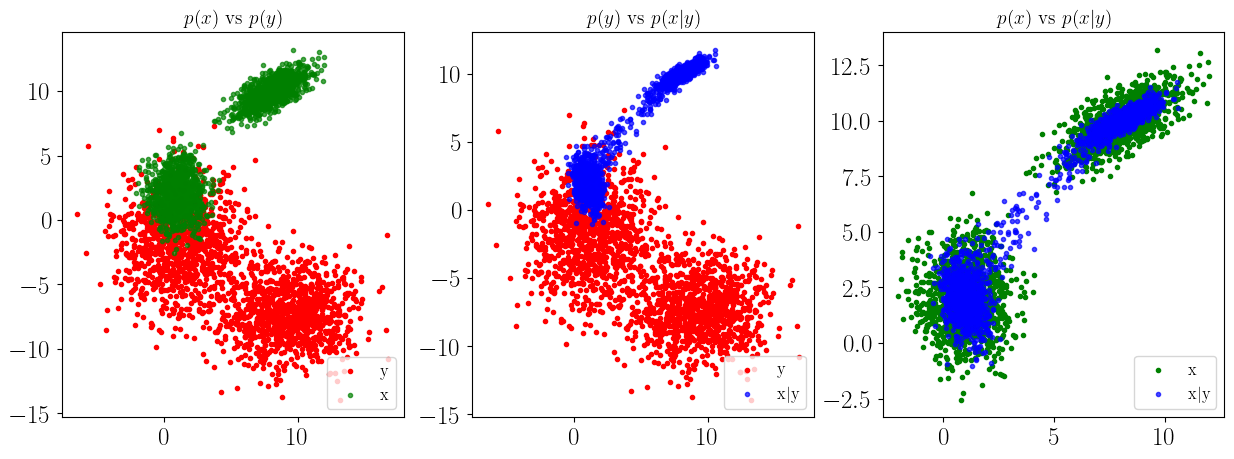

In [31]:

%matplotlib inline
mu1_real_res = mu1_real(test_samples_y, A, sigma1, sigma2, Nsigma, m1, m2)

plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.scatter(test_samples_y[0], test_samples_y[1], marker='.', color='red', alpha=1, label='y')
# sns.scatterplot(test_samples_y, marker='.', color='red', alpha=1, label='y')
plt.scatter(test_samples_x[0], test_samples_x[1], marker='.', color='green', alpha=0.7, label='x')
plt.legend(loc='lower right', fontsize=12)
plt.title('$p(x)$ vs $p(y)$', fontsize=14)

plt.subplot(1, 3, 2)
plt.scatter(test_samples_y[0], test_samples_y[1], marker='.', color='red', alpha=1, label='y')
plt.scatter(mu1_real_res[0], mu1_real_res[1], marker='.', color='blue', alpha=0.7, label='x$|$y')
plt.legend(loc='lower right', fontsize=12)
plt.title('$p(y)$ vs $p(x|y)$', fontsize=14)

plt.subplot(1, 3, 3)
plt.scatter(test_samples_x[0], test_samples_x[1], marker='.', color='green', alpha=1, label='x')
plt.scatter(mu1_real_res[0], mu1_real_res[1], marker='.', color='blue', alpha=0.7, label='x$|$y')
plt.legend(loc='lower right', fontsize=12)
plt.title('$p(x)$ vs $p(x|y)$', fontsize=14)